<a href="https://colab.research.google.com/github/Tako-San/ml-course/blob/main/t2/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [162]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.spatial import distance
from sklearn import model_selection, linear_model, metrics, svm, preprocessing

from statsmodels.stats.outliers_influence import variance_inflation_factor as vif


In [163]:
def getVIF(X):
  return pd.Series([vif(X.values, i) for i in range(X.shape[1])], index=X.columns)


In [164]:
df = pd.read_csv('train.csv')

y = df['Category'].to_frame()
X = df.drop(columns=['Id', 'Category'])
Xy = X.join(y)

vifres = getVIF(X)
if not any(val >= 5 for val in vifres):
  print('Все признаки имеют VIF < 5 => они слабо кореллируют')


Все признаки имеют VIF < 5 => они слабо кореллируют


In [165]:
# scaler = sklearn.preprocessing.StandardScaler().fit(X)
# X[X.columns] = scaler.transform(X[X.columns])

# def print_heatmap(df):
#   plt.figure(figsize=(20, 10))
#   _ = sns.heatmap(df.corr())

# print_heatmap(Xy)

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.05, random_state=0)

scaler = preprocessing.StandardScaler().fit(X_train)

X_train[X_train.columns] = scaler.transform(X_train[X_train.columns])
X_test[X_test.columns] = scaler.transform(X_test[X_test.columns])

def print_evaluation_result(ans, pred):
  fig, ax = plt.subplots(figsize=(10,6))
  ax.scatter(ans, pred)
  ax.plot(ax.get_xlim(), ax.get_ylim(), color ='red')
  plt.xlabel('True value')
  plt.ylabel('Predicted values')
  plt.title('Evaluation result')
  plt.show()

def print_result(features, target, pred):
  print("Mean squared error: %.2f" % metrics.mean_squared_error(target, pred, squared=False))
  print("Coefficient of determination: %.2f" % metrics.r2_score(target, pred)) # 1 is perfect prediction

  print_evaluation_result(target.values, pred)


Test
Mean squared error: 1799.64
Coefficient of determination: 0.03


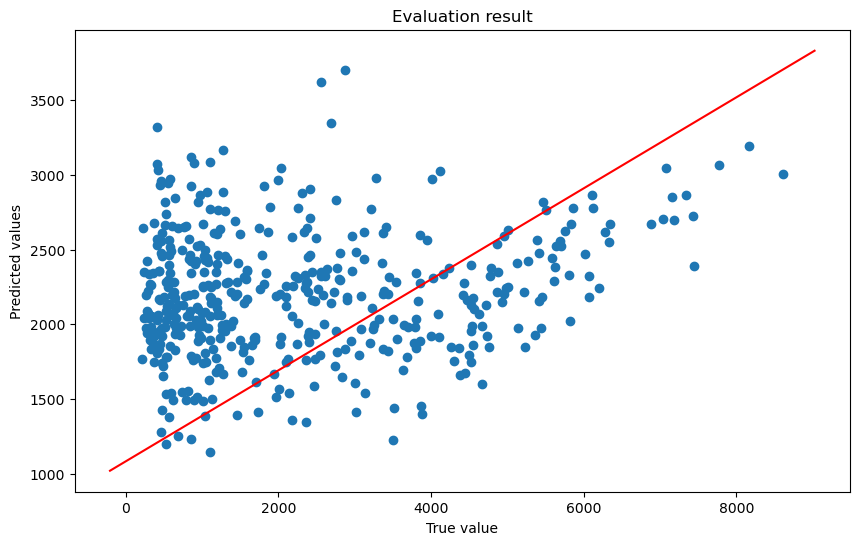

In [166]:
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)
lin_pred = regr.predict(X_test)

print("Test")
print_result(X_test, y_test, lin_pred)

# print("Train")
# print_result(X_train, y_train, regr.predict(X_train))

h_opt =  14
Test
Mean squared error: 1822.04
Coefficient of determination: 0.00


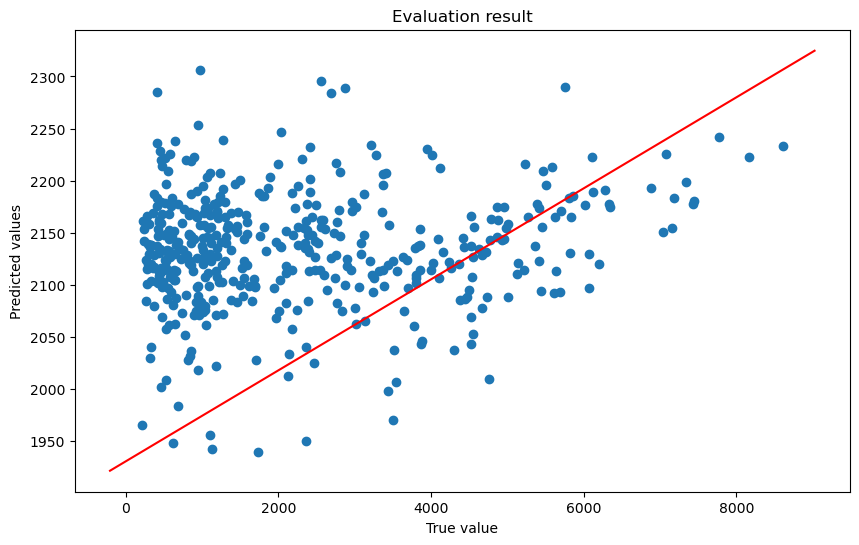

In [167]:
class FNV(object):
    def __init__(self, kernel=None):
        self.X, self.Y = None, None
        self.kernel = lambda x: np.ones_like(x)
        if kernel is not None:
            self.kernel = kernel

    def predict(self, X):
        dst = distance.cdist(X, self.X)
        kernel = self.kernel(dst)

        features = np.sum(self.Y * kernel, axis=-1)
        return features / (np.sum(kernel, axis=-1) + 1e-10)

    def fit(self, X, Y):
        self.X, self.Y = np.array(X), np.array(Y)

def K(dst, h=2):
    ret = np.array(dst)/h
    res = (1 - ret**2) * (np.abs(ret) <= 1)
    return res

# Подбор гиперпараметра
def get_optimal_h(features_train, features_test, target_train, target_test):
  min_err = 1e10
  h_opt = 0.1

  for h_i in range(0, 200):
    h = h_i * 0.1 + 0.1
    model = FNV(kernel=lambda x: K(x, h=h))
    model.fit(features_train, target_train.T)
    pred = model.predict(np.array(features_test))
    err = metrics.mean_squared_error(target_test, pred)
    if (min_err > err):
      min_err = err
      h_opt = h
  return h_opt

# h_opt = get_optimal_h(X_train, X_test, y_train, y_test)
h_opt = 14
print("h_opt = ", h_opt)

fnv = FNV(kernel=lambda x: K(x, h=h_opt))
fnv.fit(X_train, y_train.T)
fnv_pred = fnv.predict(np.array(X_test))

print("Test")
print_result(X_test, y_test, fnv_pred)
# print("Train")
# print_result(X_train, y_train, fnv.predict(np.array(X_train)))

In [168]:
def get_svr_pred(kernel):
  model = svm.SVR(kernel=kernel)
  model.fit(X_train, y_train['Category'])
  rbf_pred = model.predict(X_test)
  print("Test")
  print_result(X_test, y_test, rbf_pred)
  # print("Train")
  # print_result(X_train, y_train, model.predict(X_train))

Test
Mean squared error: 2023.23
Coefficient of determination: -0.23


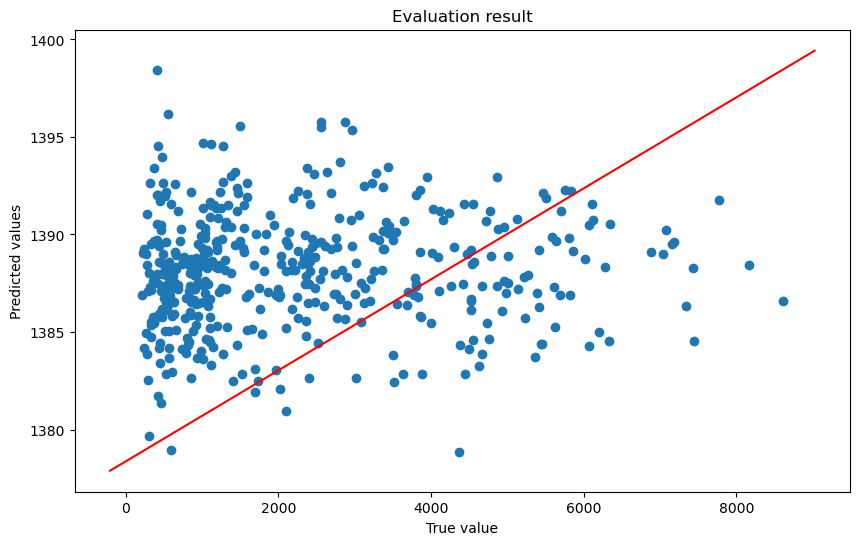

In [169]:
get_svr_pred('rbf')

Test
Mean squared error: 2022.74
Coefficient of determination: -0.23


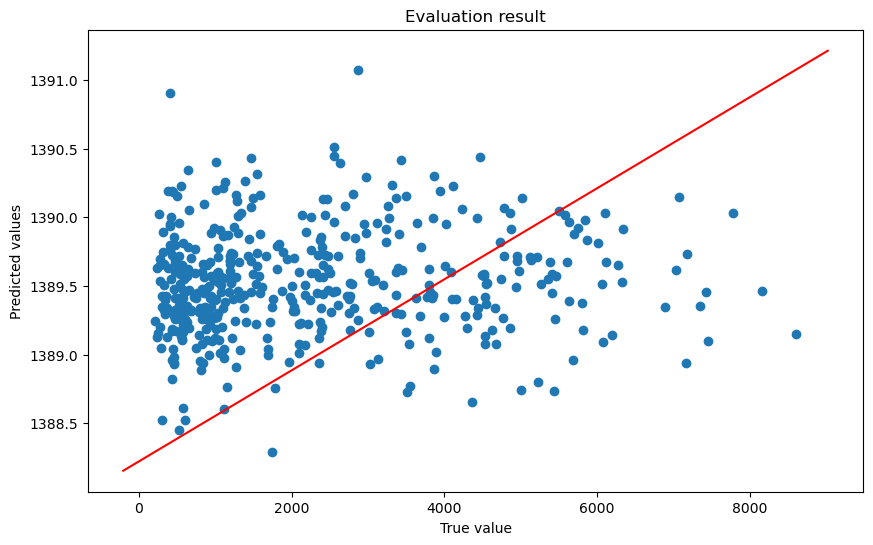

In [170]:
get_svr_pred('poly')

Test
Mean squared error: 1987.67
Coefficient of determination: -0.19


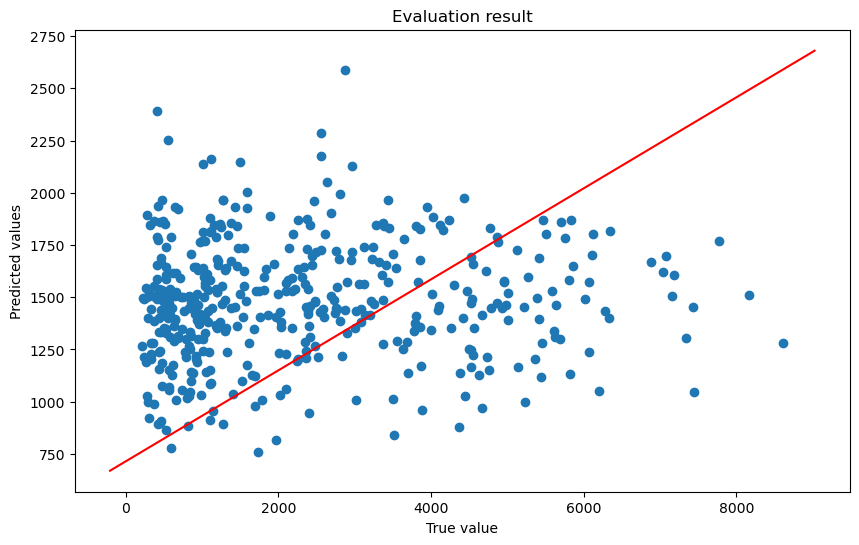

In [171]:
get_svr_pred('linear')

Test
Mean squared error: 2023.49
Coefficient of determination: -0.23


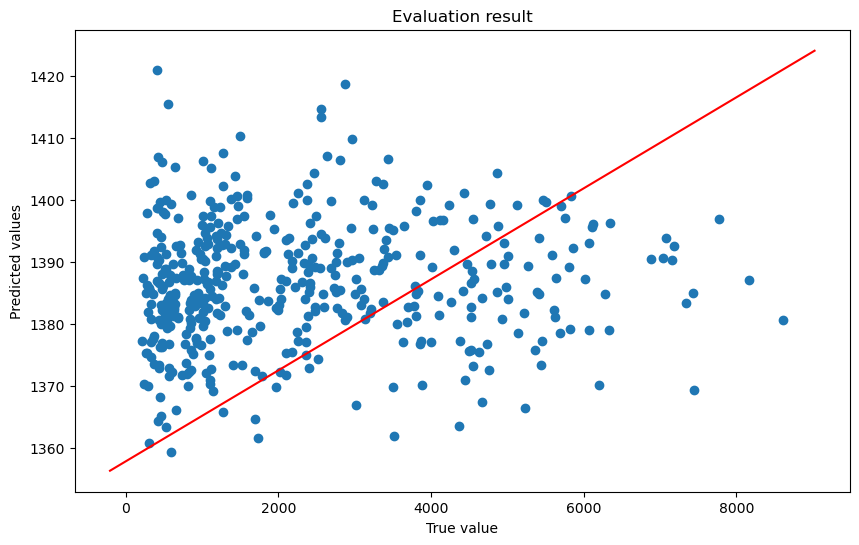

In [172]:
get_svr_pred('sigmoid')